In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Ch13 연습문제의 9번 문제에 대해 해결해본 notebook이다.**
- 요구 사항은 fashion MNIST 데이터셋을 적재하고 훈련, 검증, 테스트 세트로 나눈 뒤에 훈련 세트를 섞은 다음 각 데이터셋을 TFRecord 파일로 저장하는 것이었다. 이후 tf.data를 이용해서 각 세트를 위한 효율적인 데이터셋을 만들고 이 데이터셋을 이용해서 입력 특성을 표준화하는 전처리 층을 포함한 케라스 모델을 훈련해야 했다. 마지막으로 텐서보드로 프로파일 데이터를 시각화하여 가능한 입력 파이프라인을 효율적으로 만들라는 것이었다.

1. 우선 fashion MNIST 데이터셋을 불러오고 검증, 훈련, 테스트 데이터로 나눈다.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
len(x_train), len(x_val), len(x_test)

(48000, 12000, 10000)

2. 우선 데이터를 tf.data.Dataset의 형태로 바꾸고 훈련 세트를 shuffle()을 이용해서 섞는다.

In [4]:
BUFFER_SIZE = len(x_train)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

3. TFRecord의 형태로 저장할 수 있도록 example을 만든다.

In [5]:
from tensorflow.core.example.feature_pb2 import BytesList, FloatList, Int64List
from tensorflow.core.example.feature_pb2 import Feature, Features

In [6]:
def make_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    label = label.numpy()
    return tf.train.Example(
        features = Features(
            feature = {
                "image": Feature(bytes_list = BytesList(value = [image_data.numpy()])),
                "label": Feature(int64_list = Int64List(value = [label]))
            }
        )
    )

In [7]:
for i,l in val_dataset.take(1):
    A = (make_example(i,l))
    print(A)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\003\000\200$\000\000\000\000\000\000\0007o\000\001\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000Vne5\000\000\000Pqn:\000\001\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000x\315\277\274\202\243\303\252+\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\252\274\236\257\276\253\245\310K\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\222\342\301~}\267\265\304\240\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\253\342\337\310\274\310\222\250\262#\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000V\341\311\322\245\226\262\227\236\231\200\000\000\001\000\000\000\000\000\000\000\000\000\000\000\000\000\022\276\306\253\332\226\306\240\260\240\200\276\031\000\001\000\000\000\000\000\000\000\000\

4. Example 프로토콜 버퍼를 만들었으니 이제는 데이터의 저장 경로를 지정해 주고 TFRecord 파일로 저장해 주어야 한다.

In [8]:
def write_tfrecord(name, dataset,n_shards = 10):
    #저장 경로의 형태를 지정해주고
    path_dir = ['{}.tf_record_{:05d}_of_{:05d}'.format(name, index, n_shards ) for index in range(n_shards)]
    files = []
    for i in path_dir:
        #경로를 TFRecord의 형태로 바꾸어 주고
        files.append(tf.io.TFRecordWriter(i))
    for index, (image, label) in dataset.enumerate():
        #순서대로 데이터를 넣어주어야 함
        shard = index % n_shards
        example = make_example(image, label)
        files[shard].write(example.SerializeToString())
    return path_dir
        

In [9]:
train_rec = write_tfrecord('my_mnist.train', train_dataset, 10)
test_rec = write_tfrecord('my_mnist.test', test_dataset, 10)
val_rec = write_tfrecord('my_mnist.val', val_dataset, 10)

In [10]:
test_rec

['my_mnist.test.tf_record_00000_of_00010',
 'my_mnist.test.tf_record_00001_of_00010',
 'my_mnist.test.tf_record_00002_of_00010',
 'my_mnist.test.tf_record_00003_of_00010',
 'my_mnist.test.tf_record_00004_of_00010',
 'my_mnist.test.tf_record_00005_of_00010',
 'my_mnist.test.tf_record_00006_of_00010',
 'my_mnist.test.tf_record_00007_of_00010',
 'my_mnist.test.tf_record_00008_of_00010',
 'my_mnist.test.tf_record_00009_of_00010']

- 직렬화된 Example 프로토콜 버퍼를 읽기 위해서 tf.data.TFRecordDataset을 이용하고 tf.io.parse_single_example()을 사용하여 각 Example을 parsing 했다.
- 이 함수에는 두개의 매개 변수가 필요한데, 우선 직렬화된 데이터를 담은 문자열 스칼라 텐서와 각 특성에 대한 설명이다.
  - 이 설명이라는 것을 각 특성 이름을 특성의 크기, 타입, 기본값을 표현한 tf.io.FixedLenFeature이나 특성 리스트의 길이가 가변적인 경우에 사용하는 tf.io.VarLenFeature을 이용한다.

In [11]:
def preprocess(tfrecord):
    feature_discription = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value = ""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value = -1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_discription)
    #아래 코드는 tf.io.decode_jepg(example["image"])와 동일하다. 다만, decode를 하게 되면 이미지의 화질이 현저하게 떨어지게 된다
    image = tf.io.parse_tensor(example["image"], out_type = tf.uint8)
    image = tf.reshape(image, shape = [28,28,1])
    return image, example["label"]
    

In [12]:
def make_mnist(filepaths, n_read=5, buffer_size=None,
                  n_parse=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read)
    if cache:
        dataset = dataset.cache()
    if buffer_size:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [13]:
train_set = make_mnist(train_rec, buffer_size=len(x_train))
valid_set = make_mnist(val_rec)
test_set = make_mnist(test_rec)

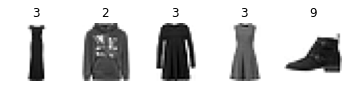

In [15]:
for i, l in train_set.take(1):
    for j in range(5):
        plt.subplot(1,5,j+1)
        plt.imshow(i[j].numpy().reshape(28,28), cmap = 'binary')
        plt.title(l[j].numpy())
        plt.axis('off')

In [16]:
class Standardization(tf.keras.layers.Layer):
    def adapt(self, data_sample):
        self.mean = np.mean(data_sample, axis=0, keepdims=True)
        self.std = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.mean) / (self.std)

standardization = Standardization(input_shape=[28, 28,1])

sample= train_set.take(100).map(lambda image, label: image)
sample = np.concatenate(list(sample.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample)

In [45]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64,input_shape = [28,28,1], kernel_size = 2, strides = 2, activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Conv2D(128, kernel_size = 2, strides = 2, activation = 'relu', padding = 'same'))
model.add(tf.keras.layers.MaxPool2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [46]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         32896     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_11 (Dense)             (None, 10)               

- 이 모델의 훈련을 위해서는 아직 label을 to_categorical()을 이용해서 one-hot tensor의 형태로 변환한 것이 아니고 10개의 정수로 이루어져 있기 때문에 loss로 sparse_categorical_crossentropy를 사용한다. 
- 그게 아니라면 loss로 categorical_crossentropy를 사용해야 한다.

In [49]:
model.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = 'nadam')

In [50]:
model.fit(train_set, validation_data = valid_set, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.7238 - accuracy: 0.7441 - val_loss: 0.4941 - val_accuracy: 0.8201
Epoch 2/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4597 - accuracy: 0.8321 - val_loss: 0.4317 - val_accuracy: 0.8447
Epoch 3/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.4170 - accuracy: 0.8476 - val_loss: 0.4064 - val_accuracy: 0.8520
Epoch 4/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3917 - accuracy: 0.8565 - val_loss: 0.3938 - val_accuracy: 0.8556
Epoch 5/5
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3733 - accuracy: 0.8629 - val_loss: 0.3865 - val_accuracy: 0.8591


In [51]:
model.evaluate(test_set)

313/313 [==============================] - 2s 5ms/step - loss: 0.4129 - accuracy: 0.8511


[0.4128890037536621, 0.8511000275611877]

### Accuracy = 85.11% (with CNN Layer)

In [54]:
prediction = model.predict(test_set)

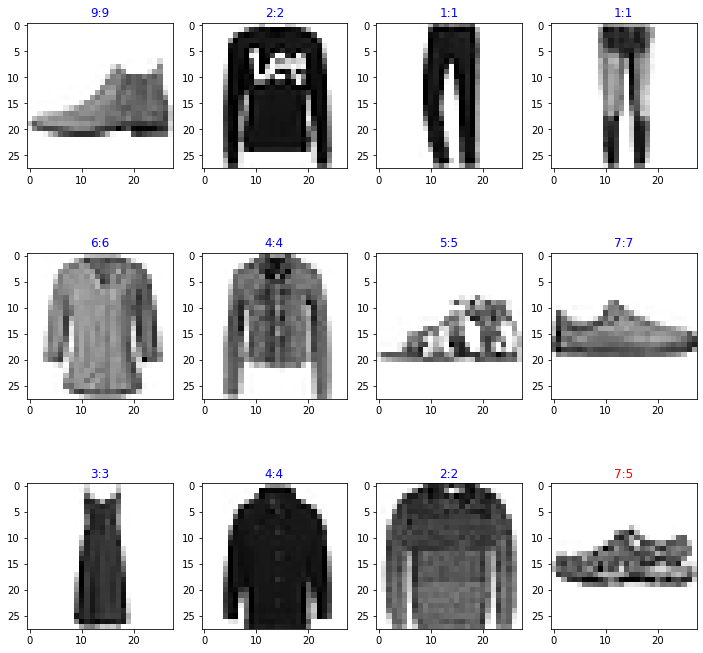

In [71]:
plt.figure(figsize=(12,12))
for img, label in test_set.take(1):
  pred = model.predict(img)
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(img[i].numpy().reshape(28,28), cmap = 'binary')
    if label[i].numpy() == np.argmax(pred[i]):plt.title('{}:{}'.format(np.argmax(pred[i]),label[i].numpy()), color = 'b')
    else:plt.title('{}:{}'.format(np.argmax(pred[i]), label[i].numpy()), color = 'r')

- 하나 빼고 다 맞추고 있음이 시각화로 확인이 가능하다.

In [52]:
model_new = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model_new.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])
model_new.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
1500/1500 [==============================] - 6s 4ms/step - loss: 3.6606 - accuracy: 0.6820 - val_loss: 0.8327 - val_accuracy: 0.7090
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.7166 - accuracy: 0.7467 - val_loss: 0.6925 - val_accuracy: 0.7431
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6157 - accuracy: 0.7874 - val_loss: 0.5629 - val_accuracy: 0.8171
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.5329 - accuracy: 0.8190 - val_loss: 0.5825 - val_accuracy: 0.8139
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5161 - accuracy: 0.8259 - val_loss: 0.5243 - val_accuracy: 0.8296


In [53]:
model_new.evaluate(test_set)

313/313 [==============================] - 1s 3ms/step - loss: 0.5481 - accuracy: 0.8169


[0.5481244921684265, 0.8169000148773193]

### Accuracy = 81.69% (Only DNN)

- 이렇게 이미지의 데이터를 TFRecord의 형태로 저장해서 이용하는 것을 해보았는데, 생각보다 너무 복잡하고 까다로웠다.
- 그리고 중간에 normalization에 오류가 있었는지 계속해서, CNN layer없이 Dense layer만 사용해고 loss = nan이 발생했지만 **Standardization층을 없애니까 바로 정확도가 올라**가 버렸다.

### 10번
- 

In [95]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
fp = tf.keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)

In [86]:
fpath = Path(fp).parent / "acllmdb"

In [88]:
fpath

PosixPath('/root/.keras/datasets/acllmdb')

In [96]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

PosixPath('/root/.keras/datasets/aclImdb')

In [97]:
import os
len(os.listdir(path))

5

In [7]:
for name,subdirs, files in os.walk(path):
  print(subdirs)
  print(name)

['test', 'train']
/root/.keras/datasets/aclImdb
['neg', 'pos']
/root/.keras/datasets/aclImdb/test
[]
/root/.keras/datasets/aclImdb/test/neg
[]
/root/.keras/datasets/aclImdb/test/pos
['neg', 'unsup', 'pos']
/root/.keras/datasets/aclImdb/train
[]
/root/.keras/datasets/aclImdb/train/neg
[]
/root/.keras/datasets/aclImdb/train/unsup
[]
/root/.keras/datasets/aclImdb/train/pos


In [8]:
def review_paths(dirpath):
  return [str(i) for i in dirpath.glob("*.txt")]

In [9]:
train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

In [10]:
train_pos[:5]

['/root/.keras/datasets/aclImdb/train/pos/8240_9.txt',
 '/root/.keras/datasets/aclImdb/train/pos/10833_10.txt',
 '/root/.keras/datasets/aclImdb/train/pos/6804_7.txt',
 '/root/.keras/datasets/aclImdb/train/pos/5301_8.txt',
 '/root/.keras/datasets/aclImdb/train/pos/9590_10.txt']

In [11]:
len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

#### 2. 문제에서 요구한 대로 테스트 세트를 검증세트 15000개와 테스트 세트 10000개로 나누고자 한다.

In [12]:
np.random.shuffle(test_valid_pos)
np.random.shuffle(test_valid_neg)

test_pos, val_pos = test_valid_pos[:5000], test_valid_pos[5000:]
test_neg, val_neg = test_valid_neg[:5000], test_valid_neg[5000:]

#### 3. tf.data.Dataset을 이용해서 각 세트에 대한 효율적인 데이터세트를 만든다.
- 아무래도 훈련의 목적이 텍스트 데이터에 대해서 긍정, 부정을 검사 하는 것이다 보니까 labeling을 할 때에 긍정은 1, 부정은 0으로 하면 될 것이라고 생각했다.
- 그래서 데이터셋에 대해서 텍스트 데이터와 라벨을 묶어서 dataset으로 반환하기 위해서 지금까지 위에서 만든 리스트가 어떤 정보를 담은 것인지 잊지 말아야 한다.
  - 위에서 shuffle 하고 train, test, val으로 나눈 것들은 모두 **저장 경로**이고 우리는 이 저장 경로를 이용해서 학습 하는 것이 아니라 **저장 경로에 담긴 데이터를 이용해 학습**하는 것이다.
  - 따라서 ```
  with open(filepath) as f:
  file.append(f.read())```
    이런 식으로 데이터를 읽어서 tf.data.Dataset의 형태로 바꾸어야 한다.

In [15]:
def imdb_dataset(pos, neg):
  review, labels = [],[]
  for filepath, label in ((neg, 0), (pos, 1)):
    for i in filepath:
      with open(i) as f:
        review.append(f.read())
      labels.append(label)
  return tf.data.Dataset.from_tensor_slices((tf.constant(review), tf.constant(labels)))


In [17]:
for x, y in imdb_dataset(test_pos, test_neg).take(3):
  print(x)
  print(y)

tf.Tensor(b'There is no real story the film seems more like a fly on the wall drama-documentary than a proper film so this piece may in itself be a spoiler. Teen drama about 3 young Singaporean kids (very similar to UK chavs) who play truant from school, run with gangs, get into fights, insult people on the street, get tattoos, hang about doing nothing, etc. etc, They generally imagine themselves to be hard and every so often shout challenging rap chants into the camera. Filmed in MTV style, fast cuts, crazy camera angles, tight close ups and animation interludes. The dialogue might have been crisper in the original languages of Mandarin and Hokkien than in the subtitles and I have no doubt that some of the contemporary Singapore references will slip over Western heads as well as the cultural and political context unless of course you are familiar with Singapore. This kind of teen film may be a first for Singapore but it has been done before and done better in other Western countries, 

In [123]:
batch_size = 32
train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
val_set = imdb_dataset(val_pos, val_neg).shuffle(10000).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).shuffle(10000).batch(batch_size).prefetch(1)

- 만약에 이 데이터의 양이 너무 많아서 전부다 읽어들이는데 시간이 많이 걸릴 경우에는 tf.data.TextLineDataset을 이용해서 한줄 씩 읽어 나갈 수 도 있다.
```py3
def imdb_dataset(pos_path, neg_path, n_read= 5):  
    data_pos = tf.data.TextLineDataset(pos_path, num_parallel_reads = n_read)   
    data_pos = data_pos.map(lambda review: (review, 1))  
    data_neg = tf.data.TextLineDataset(neg_path, num_parallel_reads = n_read)  
    data_neg = data_neg.map(lambda review: (review, 0))  
    return tf.data.Dataset.concatenate(data_pos, data_neg)```


#### 4. 범부형 데이터이기 때문에 수치형 데이터로 바꾸어 주어야 하는데, 이를 위해서 먼저 preprocess함수를 만들어 준다.
- 이 함수에는 일단 텍스트의 각 단어들을 label로 바꾸어 줄 TextVectorization이 진행이 되어야 한다.
- 우선 그냥 keras API의 TextVectorization layer을 그냥 이용해 본 이후에 사용자 정의 층으로 구현을 해보고자 한다.

In [18]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [98]:
max_features = 1100 # Maximum vocab size.
max_len = 100  # Sequence length to pad the outputs to.
embedding_dims = 2

In [99]:
vectorize_layer = TextVectorization(
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = max_len
)

In [100]:
sample = train_set.map(lambda image, labels: image)
sample = np.concatenate(list(sample.as_numpy_iterator()), axis = 0)

In [101]:
sample

array([b"OK so after watching this invigorating movie and wasting an hour and so many minutes off my life here is the basic summary: Genie comes out of ghetto boom box, gives this kid with shaggy hair 3 wishes, the kid wastes his wishes on i forget what, shaq sucks at rapping, and i guess thats it.<br /><br />So mainly I laughed, I cried......but mainly I laughed at the shear comedy that came from the wonderful acting skills of an nba player/rapper and boy with shaggy hair.<br /><br />I highly recommend this movie for college kids sitting around drinking some beers with their close friends and are in serious need of a good laugh.<br /><br />I'm going to give it a 3 out of 10 only b/c the movie is based off of 3 magical wishes.<br /><br />If I had 3 wishes one would be to erase this horrible movie and for everyone to pretend like Hollywood didn't waste money on making this.",
       b'This movie seemed like it was going to be better than it ended up being. The cinematography is good, th

In [102]:
vectorize_layer.adapt(sample)

In [103]:
vectorize_layer(sample)

<tf.Tensor: shape=(25000, 100), dtype=int64, numpy=
array([[597,  38, 101, ...,   1,  47,   1],
       [ 11,  18, 446, ...,   2,   1,   1],
       [ 87,   1,   2, ..., 286,  10, 237],
       ...,
       [  1,   1,   7, ...,   0,   0,   0],
       [230,   1, 838, ..., 461,   2,  20],
       [ 11,   1,  10, ..., 156,  10,   1]])>

In [76]:
from tensorflow.keras.layers.experimental.preprocessing import Discretization
onehot_layer = Discretization(bins = vectorize_layer(sample))

In [77]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [78]:
print(onehot.fit(vectorize_layer(sample)))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)


In [109]:
class BagOfWords(tf.keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=tf.int32, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]




n_tokens = 1101 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

In [129]:
bag_of_words(vectorize_layer(sample))[0]

<tf.Tensor: shape=(1100,), dtype=float32, numpy=array([29.,  4.,  4., ...,  0.,  0.,  0.], dtype=float32)>

In [110]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(vectorize_layer)
model.add(bag_of_words)
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [111]:
model.compile(loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

In [112]:
model.fit(train_set, validation_data = val_set, epochs = 20)

Epoch 1/20
782/782 [==============================] - 14s 18ms/step - loss: 0.4755 - accuracy: 0.7686 - val_loss: 0.4301 - val_accuracy: 0.7983
Epoch 2/20
782/782 [==============================] - 14s 18ms/step - loss: 0.4164 - accuracy: 0.8090 - val_loss: 0.4330 - val_accuracy: 0.7949
Epoch 3/20
782/782 [==============================] - 13s 16ms/step - loss: 0.3849 - accuracy: 0.8244 - val_loss: 0.4306 - val_accuracy: 0.7969
Epoch 4/20
782/782 [==============================] - 13s 17ms/step - loss: 0.3408 - accuracy: 0.8503 - val_loss: 0.4390 - val_accuracy: 0.7941
Epoch 5/20
782/782 [==============================] - 13s 17ms/step - loss: 0.2814 - accuracy: 0.8847 - val_loss: 0.4931 - val_accuracy: 0.7707
Epoch 6/20
782/782 [==============================] - 13s 16ms/step - loss: 0.2196 - accuracy: 0.9182 - val_loss: 0.4784 - val_accuracy: 0.7871
Epoch 7/20
782/782 [==============================] - 13s 16ms/step - loss: 0.1579 - accuracy: 0.9488 - val_loss: 0.5324 - val_accuracy:

In [127]:
model.evaluate(test_set)

313/313 [==============================] - 3s 9ms/step - loss: 1.3465 - accuracy: 0.7691


[1.3465012311935425, 0.76910001039505]

### Accuracy = 76.91%

In [126]:
for review, label in test_set.take(1):
  predict = model.predict(review)
  for j in range(20):
    ans = np.argmax(predict[j])
    print('{}:{}'.format(ans,label[j]))


0:1
0:1
0:0
0:1
0:1
0:0
0:1
0:0
0:0
0:0
0:0
0:1
0:0
0:0
0:1
0:0
0:1
0:0
0:0
0:1
